In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import copy
from cryptography.hazmat.primitives import hashes, serialization
from cryptography.hazmat.primitives.asymmetric import dh
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
import pickle
import sys

import os



In [2]:
import pandas as pd
import seaborn as sns
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2

from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/cs-lab-12/.anaconda3/envs/he39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("drone/class_dict_seg.csv")

In [4]:
clients = [0 , 1]
no_clients = len(clients)
epochs = 2

In [5]:
image_path = "drone/dataset/semantic_drone_dataset/label_images_semantic"
original_image_path = "drone/dataset/semantic_drone_dataset/original_images"

In [6]:
files = os.listdir(image_path)

# Filter out only the image files (assuming image files have extensions like .jpg, .png, etc.)
image_files = [
    file for file in files if file.endswith((".jpg", ".jpeg", ".png", ".gif", ".bmp"))
]
image_files = sorted(image_files)

# list o image_paths
image_list = []
# Print the list of image files
for image_file in image_files:
    image_list.append(image_path + "/" + image_file)


files_2 = os.listdir(original_image_path)
# Filter out only the image files (assuming image files have extensions like .jpg, .png, etc.)
image_files = [
    file for file in files_2 if file.endswith((".jpg", ".jpeg", ".png", ".gif", ".bmp"))
]
image_files = sorted(image_files)

# list o image_paths
original_image_list = []
# Print the list of image files
for image_file in image_files:
    original_image_list.append(original_image_path + "/" + image_file)

In [7]:
IMAGE_PATH = "drone/dataset/semantic_drone_dataset/original_images"
MASK_PATH = "drone/dataset/semantic_drone_dataset/label_images_semantic"

In [8]:
n_classes = 23


def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split(".")[0])

    return pd.DataFrame({"id": name}, index=np.arange(0, len(name)))


df = create_df()
print("Total Images: ", len(df))

Total Images:  400


In [9]:
df.iloc[0]

id    515
Name: 0, dtype: object

In [10]:
# spliting the data for traning , testing and validation
X_trainval, X_test = train_test_split(df["id"].values, test_size=0.1, random_state=42)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=42)

In [11]:
split_train = [X_train[i*len(X_train)//no_clients:(i+1)*len(X_train)//no_clients] for i in range(no_clients)]
split_val = [X_val[i*len(X_val)//no_clients:(i+1)*len(X_val)//no_clients] for i in range(no_clients)]

In [12]:
len(split_train[0])

153

In [13]:
class DroneDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_full_path = os.path.join(self.img_path, self.X[idx] + ".jpg")
        mask_full_path = os.path.join(self.mask_path, self.X[idx] + ".png")

        # Load the image and mask
        img = cv2.imread(img_full_path)
        if img is None:
            raise FileNotFoundError(f"Image not found at {img_full_path}")

        mask = cv2.imread(mask_full_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask not found at {mask_full_path}")

        # Convert color from BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug["image"])
            mask = aug["mask"]

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches = img_patches.contiguous().view(3, -1, 512, 768)
        img_patches = img_patches.permute(1, 0, 2, 3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

In [14]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

t_train = A.Compose(
    [
        A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.GridDistortion(p=0.2),
        A.RandomBrightnessContrast((0, 0.5), (0, 0.5)),
        A.GaussNoise(),
    ]
)

t_val = A.Compose(
    [
        A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(),
        A.GridDistortion(p=0.2),
    ]
)

# datasets
train_set = DroneDataset(
    IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False
)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

# dataloader
batch_size = 1

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [15]:
# datasets
train_loaders = []
val_loaders = [] 
for i in range(no_clients):
    b_train = split_train[i]
    b_val = split_val[i]
    train_set = DroneDataset(
        IMAGE_PATH, MASK_PATH, b_train, mean, std, t_train, patch=False
    )
    val_set = DroneDataset(IMAGE_PATH, MASK_PATH, b_val, mean, std, t_val, patch=False)

    # dataloader
    batch_size = 1

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

In [16]:
models = []
for i in range(no_clients):
    model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=3,
        classes=n_classes,
    )
    models.append(model)

In [17]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [18]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes):  # loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0:  # no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = (
                    torch.logical_and(true_class, true_label).sum().float().item()
                )
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [19]:
import numpy as np
import matplotlib.pyplot as plt


def plot(pred_masks, true_masks):
    n_classes = len(np.unique(true_masks))  # Number of unique classes
    class_colors = plt.cm.tab20.colors  # Colors for different classes

    n_images = pred_masks.shape[0]  # Number of images

    # Create subplots outside the loop
    fig, axes = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))

    for i in range(n_images):
        im_pred = axes[i, 0].imshow(
            pred_masks[i, 0], cmap="tab20", vmin=0, vmax=n_classes - 1
        )  # Assuming single channel masks
        axes[i, 0].set_title("Predicted Mask")
        axes[i, 0].set_axis_off()
        fig.colorbar(im_pred, ax=axes[i, 0], label="Predicted Class")

        im_true = axes[i, 1].imshow(
            true_masks[i], cmap="tab20", vmin=0, vmax=n_classes - 1
        )
        axes[i, 1].set_title("True Mask")
        axes[i, 1].set_axis_off()
        fig.colorbar(im_true, ax=axes[i, 1], label="True Class")

    plt.tight_layout()
    plt.show()

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import time
from tqdm import tqdm
import learn2learn as l2l


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


def fit(
    epochs,
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    patch=False,
    adaptation_steps=5,
    inner_lr=0.01,
):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []
    val_acc = []
    train_iou = []
    train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1
    not_improve = 0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0

        # training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            # training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()
                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device)
            mask = mask_tiles.to(device)

            # Meta-learning with MAML
            optimizer.zero_grad()

            # Clone the model for inner-loop updates
            learner = l2l.algorithms.MAML(model, lr=inner_lr).clone()

            # Inner loop: Adaptation
            for step in range(adaptation_steps):
                output = learner(image)
                loss = criterion(output, mask)
                learner.adapt(loss)

            # Meta-update
            output = learner(image)
            loss = criterion(output, mask)
            loss.backward()
            optimizer.step()

            # Step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()
            # Evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)

        # Validation loop
        model.eval()
        test_loss = 0
        test_accuracy = 0
        val_iou_score = 0
        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader)):
                image_tiles, mask_tiles = data
                if patch:
                    bs, n_tiles, c, h, w = image_tiles.size()
                    image_tiles = image_tiles.view(-1, c, h, w)
                    mask_tiles = mask_tiles.view(-1, h, w)

                image = image_tiles.to(device)
                mask = mask_tiles.to(device)

                output = model(image)
                val_iou_score += mIoU(output, mask)
                test_accuracy += pixel_accuracy(output, mask)
                loss = criterion(output, mask)
                test_loss += loss.item()

        # Calculate mean for each batch
        train_losses.append(running_loss / len(train_loader))
        test_losses.append(test_loss / len(val_loader))

        if min_loss > (test_loss / len(val_loader)):
            print(
                "Loss Decreasing.. {:.3f} >> {:.3f} ".format(
                    min_loss, (test_loss / len(val_loader))
                )
            )
            min_loss = test_loss / len(val_loader)
            decrease += 1
            if decrease % 5 == 0:
                print("saving model...")
                torch.save(
                    model,
                    "Unet-Mobilenet_v2_mIoU-{:.3f}.pt".format(
                        val_iou_score / len(val_loader)
                    ),
                )

        if (test_loss / len(val_loader)) > min_loss:
            not_improve += 1
            min_loss = test_loss / len(val_loader)
            print(f"Loss Not Decrease for {not_improve} time")
            if not_improve == 7:
                print("Loss not decrease for 7 times, Stop Training")
                break

        # Update metrics
        val_iou.append(val_iou_score / len(val_loader))
        train_iou.append(iou_score / len(train_loader))
        train_acc.append(accuracy / len(train_loader))
        val_acc.append(test_accuracy / len(val_loader))
        print(
            "Epoch:{}/{}..".format(e + 1, epochs),
            "Train Loss: {:.3f}..".format(running_loss / len(train_loader)),
            "Val Loss: {:.3f}..".format(test_loss / len(val_loader)),
            "Train mIoU:{:.3f}..".format(iou_score / len(train_loader)),
            "Val mIoU: {:.3f}..".format(val_iou_score / len(val_loader)),
            "Train Acc:{:.3f}..".format(accuracy / len(train_loader)),
            "Val Acc:{:.3f}..".format(test_accuracy / len(val_loader)),
            "Time: {:.2f}m".format((time.time() - since) / 60),
        )

    history = {
        "train_loss": train_losses,
        "val_loss": test_losses,
        "train_miou": train_iou,
        "val_miou": val_iou,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "lrs": lrs,
    }
    print("Total time: {:.2f} m".format((time.time() - fit_time) / 60))
    return history

In [21]:
# max_lr = 1e-3
# epoch = 2
# weight_decay = 1e-4

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
# sched = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_loader)
# )

# history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

In [22]:
def fed_train(model):
    history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)
    return model , history

In [23]:
import numpy as np
from Pyfhel import Pyfhel

HE = Pyfhel()
ckks_params = {
    "scheme": "CKKS",
    "n": 2**14,  # Polynomial modulus degree. For CKKS, n/2 values can be
    "scale": 2**30,  # All the encodings will use it for float->fixed point
    "qi_sizes": [60, 30, 30, 30, 60],  # Number of bits of each prime in the chain.
}
HE.contextGen(**ckks_params)  # Generate context for ckks scheme
HE.keyGen()  # Key Generation: generates a pair of public/secret keys
HE.rotateKeyGen()

In [24]:
def generate_diffie_hellman_parameters():
    parameters = dh.generate_parameters(generator=2, key_size=512)
    return parameters


def generate_diffie_hellman_keys(parameters):
    private_key = parameters.generate_private_key()
    public_key = private_key.public_key()
    return private_key, public_key


def derive_key(private_key, peer_public_key):
    shared_key = private_key.exchange(peer_public_key)
    derived_key = HKDF(
        algorithm=hashes.SHA256(),
        length=32,
        salt=None,
        info=b"handshake data",
    ).derive(shared_key)
    return derived_key


def encrypt_message_AES(key, message):
    serialized_obj = pickle.dumps(message)
    cipher = Cipher(algorithms.AES(key), modes.ECB())
    encryptor = cipher.encryptor()
    padded_obj = serialized_obj + b" " * (16 - len(serialized_obj) % 16)
    ciphertext = encryptor.update(padded_obj) + encryptor.finalize()
    return ciphertext


def decrypt_message_AES(key, ciphertext):
    cipher = Cipher(algorithms.AES(key), modes.ECB())
    decryptor = cipher.decryptor()
    padded_obj = decryptor.update(ciphertext) + decryptor.finalize()
    serialized_obj = padded_obj.rstrip(b" ")
    obj = pickle.loads(serialized_obj)
    return obj


def setup_AES():
    num_clients = len(clients)
    parameters = generate_diffie_hellman_parameters()
    server_private_key, server_public_key = generate_diffie_hellman_keys(parameters)
    client_keys = [generate_diffie_hellman_keys(parameters) for _ in range(num_clients)]
    shared_keys = [
        derive_key(server_private_key, client_public_key)
        for _, client_public_key in client_keys
    ]
    client_shared_keys = [
        derive_key(client_private_key, server_public_key)
        for client_private_key, _ in client_keys
    ]

    return client_keys, shared_keys, client_shared_keys

client_keys, shared_keys, client_shared_keys = setup_AES()

In [25]:
def load_weights(model, weights):
    with torch.no_grad(): 
        for param, weight in zip(model.parameters(), weights):
            param.copy_(torch.tensor(weight))
    return model

In [26]:
def get_weights(model):
    return [param.cpu().detach().numpy() for param in model.parameters()]

In [27]:
def aggregate_wt(encypted_cwts):
    # cwts = []
    # for i, ecwt in enumerate(encypted_cwts):
    #     cwts.append(decrypt_message_AES(shared_keys[i], ecwt))
    cwts = encypted_cwts
    resmodel = []
    for j in range(len(cwts[0])):  # for layers
        layer = []
        for k in range(len(cwts[0][j])):  # for chunks
            tmp = cwts[0][j][k].copy()
            for i in range(1, len(cwts)):  # for clients
                tmp = tmp + cwts[i][j][k]
            tmp = tmp / len(cwts)
            layer.append(tmp)
        resmodel.append(layer)

    res = [resmodel.copy() for _ in range(len(clients))]
    return res

In [28]:
def encrypt_wt(wtarray, i):
    cwt = []
    for layer in wtarray:
        flat_array = layer.astype(np.float64).flatten()

        chunks = np.array_split(flat_array, (len(flat_array) + 2**13 - 1) // 2**13)
        clayer = []
        for chunk in chunks:
            ptxt = HE.encodeFrac(chunk)
            ctxt = HE.encryptPtxt(ptxt)
            clayer.append(ctxt)
        cwt.append(clayer.copy())
    # ciphertext = encrypt_message_AES(client_shared_keys[i], cwt)
    return cwt

In [29]:
def decrypt_weights(res):
    decrypted_weights = []
    for client_weights, model in zip(res, models):
        decrypted_client_weights = []
        wtarray = get_weights(model)
        for layer_weights, layer in zip(client_weights, wtarray):
            decrypted_layer_weights = []
            flat_array = layer.astype(np.float64).flatten()
            chunks = np.array_split(flat_array, (len(flat_array) + 2**13 - 1) // 2**13)
            for chunk, encrypted_chunk in zip(chunks, layer_weights):
                decrypted_chunk = HE.decryptFrac(encrypted_chunk)
                original_chunk_size = len(chunk)
                decrypted_chunk = decrypted_chunk[:original_chunk_size]
                decrypted_layer_weights.append(decrypted_chunk)
            decrypted_layer_weights = np.concatenate(decrypted_layer_weights, axis=0)
            decrypted_layer_weights = decrypted_layer_weights.reshape(layer.shape)
            decrypted_client_weights.append(decrypted_layer_weights)
        decrypted_weights.append(decrypted_client_weights)
    return decrypted_weights

In [30]:
max_lr = 0.01
weight_decay = 0.01

In [31]:
# histories = []
# cwts = [encrypt_wt(get_weights(model), i) for i, model in enumerate(models)]
# print("Initial encrypted weights generated for all clients.")

# for e in range(epochs):
#     print(f"Epoch {e+1}/{epochs} started")
    
#     cwts = aggregate_wt(cwts)
#     print(f"Aggregated encrypted weights after epoch {e+1}")
    
#     wts = decrypt_weights(cwts)
#     print(f"Decrypted weights after aggregation for epoch {e+1}")
    
#     cwts = []
#     epoch_histories = []
    
#     for i in range(no_clients):
#         print(f"Client {i} preparing to load weights and datasets for epoch {e+1}")
        
#         wt = wts[i]
#         model = load_weights(models[i], wt)
        
#         train_loader = train_loaders[i]
#         val_loader = val_loaders[i]
        
#         criterion = nn.CrossEntropyLoss()
#         optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
#         sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=1, steps_per_epoch=len(train_loader))
        
#         print(f"Client {i} Epoch {e+1} started")
        
#         history = fit(1, model, train_loader, val_loader, criterion, optimizer, sched)
        
#         epoch_histories.append(history)
#         print(f"Client {i} Epoch {e+1} completed with history: {history}")
        
#         wtarray = get_weights(model)
#         cwts.append(encrypt_wt(wtarray, i))
#         print(f"Client {i} weights encrypted and added to cwts for epoch {e+1}")

#     histories.append(epoch_histories)
#     print(f"Epoch {e+1} completed and histories updated")

# print("Training completed.")


In [32]:
# from tqdm import tqdm

# histories = []
# previous_losses = {i: [] for i in range(no_clients)}

# cwts = [encrypt_wt(get_weights(model), i) for i, model in enumerate(models)]
# print("Initial encrypted weights generated for all clients.")

# for e in tqdm(range(epochs), desc="Epochs", colour='green'):
#     print(f"Epoch {e+1}/{epochs} started")
    
#     cwts = aggregate_wt(cwts)
#     print(f"Aggregated encrypted weights after epoch {e+1}")
    
#     wts = decrypt_weights(cwts)
#     print(f"Decrypted weights after aggregation for epoch {e+1}")
    
#     cwts = []
#     epoch_histories = []
    
#     for i in range(no_clients):
#         print(f"Client {i} preparing to load weights and datasets for epoch {e+1}")
        
#         wt = wts[i]
#         model = load_weights(models[i], wt)
        
#         train_loader = train_loaders[i]
#         val_loader = val_loaders[i]
        
#         criterion = nn.CrossEntropyLoss()
#         optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
#         sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=1, steps_per_epoch=len(train_loader))
        
#         print(f"Client {i} previous losses before epoch {e+1}: {previous_losses[i]}")
#         print(f"Client {i} Epoch {e+1} started")
        
#         history = fit(1, model, tqdm(train_loader, desc=f"Client {i} Training", colour='blue'), val_loader, criterion, optimizer, sched)
        
#         epoch_histories.append(history)
#         print(f"Client {i} Epoch {e+1} completed with history: {history}")
        
#         previous_losses[i].append({
#             'train_loss': history['train_loss'][-1],
#             'val_loss': history['val_loss'][-1]
#         })
#         print(f"Client {i} previous losses updated: {previous_losses[i]}")
        
#         wtarray = get_weights(model)
#         cwts.append(encrypt_wt(wtarray, i))
#         print(f"Client {i} weights encrypted and added to cwts for epoch {e+1}")

#     histories.append(epoch_histories)
#     print(f"Epoch {e+1} completed and histories updated")

# print("Training completed.")



In [33]:
# # Plotting accuracy over time
# train_accuracies = {i: [] for i in range(no_clients)}
# val_accuracies = {i: [] for i in range(no_clients)}

# for epoch_histories in histories:
#     for i, history in enumerate(epoch_histories):
#         train_accuracies[i].append(history["train_accuracy"][-1])
#         val_accuracies[i].append(history["val_accuracy"][-1])

# plt.figure(figsize=(10, 6))

# for i in range(no_clients):
#     plt.plot(train_accuracies[i], label=f"Client {i} Train Accuracy")
#     plt.plot(val_accuracies[i], label=f"Client {i} Val Accuracy")

# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.title("Training and Validation Accuracy Over Time")
# plt.legend()
# plt.grid(True)
# plt.show()

In [34]:

# for e, epoch_histories in enumerate(histories):
#     print(f"Epoch {e+1} histories:")
#     for i, history in enumerate(epoch_histories):
#         print(f"  Client {i}: {history}")

In [35]:
epochs = 3

In [36]:
def fit(
    epochs,
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    patch=False,
    adaptation_steps=5,
    inner_lr=0.01,
):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []
    val_acc = []
    train_iou = []
    train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1
    not_improve = 0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0

        # training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            # training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()
                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device)
            mask = mask_tiles.to(device)

            # Meta-learning with MAML
            optimizer.zero_grad()

            # Clone the model for inner-loop updates
            learner = l2l.algorithms.MAML(model, lr=inner_lr).clone()

            # Inner loop: Adaptation
            for step in range(adaptation_steps):
                output = learner(image)
                loss = criterion(output, mask)
                learner.adapt(loss)

            # Meta-update
            output = learner(image)
            loss = criterion(output, mask)
            loss.backward()
            optimizer.step()

            # Step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()
            # Evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)

        # Validation loop
        model.eval()
        test_loss = 0
        test_accuracy = 0
        val_iou_score = 0
        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader)):
                image_tiles, mask_tiles = data
                if patch:
                    bs, n_tiles, c, h, w = image_tiles.size()
                    image_tiles = image_tiles.view(-1, c, h, w)
                    mask_tiles = mask_tiles.view(-1, h, w)

                image = image_tiles.to(device)
                mask = mask_tiles.to(device)

                output = model(image)
                val_iou_score += mIoU(output, mask)
                test_accuracy += pixel_accuracy(output, mask)
                loss = criterion(output, mask)
                test_loss += loss.item()

        # Calculate mean for each batch
        train_losses.append(running_loss / len(train_loader))
        test_losses.append(test_loss / len(val_loader))

        if min_loss > (test_loss / len(val_loader)):
            print(
                "Loss Decreasing.. {:.3f} >> {:.3f} ".format(
                    min_loss, (test_loss / len(val_loader))
                )
            )
            min_loss = test_loss / len(val_loader)
            decrease += 1
            if decrease % 5 == 0:
                print("saving model...")
                torch.save(
                    model,
                    "Unet-Mobilenet_v2_mIoU-{:.3f}.pt".format(
                        val_iou_score / len(val_loader)
                    ),
                )

        if (test_loss / len(val_loader)) > min_loss:
            not_improve += 1
            min_loss = test_loss / len(val_loader)
            print(f"Loss Not Decrease for {not_improve} time")
            if not_improve == 7:
                print("Loss not decrease for 7 times, Stop Training")
                break

        # Update metrics
        val_iou.append(val_iou_score / len(val_loader))
        train_iou.append(iou_score / len(train_loader))
        train_acc.append(accuracy / len(train_loader))
        val_acc.append(test_accuracy / len(val_loader))
        print(
            "Epoch:{}/{}..".format(e + 1, epochs),
            "Train Loss: {:.3f}..".format(running_loss / len(train_loader)),
            "Val Loss: {:.3f}..".format(test_loss / len(val_loader)),
            "Train mIoU:{:.3f}..".format(iou_score / len(train_loader)),
            "Val mIoU: {:.3f}..".format(val_iou_score / len(val_loader)),
            "Train Acc:{:.3f}..".format(accuracy / len(train_loader)),
            "Val Acc:{:.3f}..".format(test_accuracy / len(val_loader)),
            "Time: {:.2f}m".format((time.time() - since) / 60),
        )

    history = {
        "train_loss": train_losses,
        "val_loss": test_losses,
        "train_miou": train_iou,
        "val_miou": val_iou,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "lrs": lrs,
    }
    print("Total time: {:.2f} m".format((time.time() - fit_time) / 60))
    return history

In [37]:
histories = []
previous_losses = {i: [] for i in range(no_clients)}

cwts = [encrypt_wt(get_weights(model), i) for i, model in enumerate(models)]
print("Initial encrypted weights generated for all clients.")

for e in tqdm(range(epochs), desc="Epochs", colour="green"):
    print(f"Epoch {e+1}/{epochs} started")

    cwts = aggregate_wt(cwts)
    print(f"Aggregated encrypted weights after epoch {e+1}")

    wts = decrypt_weights(cwts)
    print(f"Decrypted weights after aggregation for epoch {e+1}")

    cwts = []
    epoch_histories = []

    for i in range(no_clients):
        print(f"Client {i} preparing to load weights and datasets for epoch {e+1}")

        wt = wts[i]
        model = load_weights(models[i], wt)

        train_loader = train_loaders[i]
        val_loader = val_loaders[i]

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(
            model.parameters(), lr=max_lr, weight_decay=weight_decay
        )
        sched = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr, epochs=1, steps_per_epoch=len(train_loader)
        )

        print(f"Client {i} previous losses before epoch {e+1}: {previous_losses[i]}")
        print(f"Client {i} Epoch {e+1} started")

        history = fit(
            1,
            model,
            tqdm(train_loader, desc=f"Client {i} Training", colour="blue"),
            val_loader,
            criterion,
            optimizer,
            sched,
        )

        epoch_histories.append(history)
        print(f"Client {i} Epoch {e+1} completed with history: {history}")

        previous_losses[i].append(
            {
                "train_loss": history["train_loss"][-1],
                "val_loss": history["val_loss"][-1],
                "train_acc": history["train_acc"][-1],
                "val_acc": history["val_acc"][-1],
            }
        )
        print(f"Client {i} previous losses updated: {previous_losses[i]}")

        wtarray = get_weights(model)
        cwts.append(encrypt_wt(wtarray, i))
        print(f"Client {i} weights encrypted and added to cwts for epoch {e+1}")

    histories.append(epoch_histories)
    print(f"Epoch {e+1} completed and histories updated")

print("Training completed.")

Initial encrypted weights generated for all clients.


Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 started
Aggregated encrypted weights after epoch 1
Decrypted weights after aggregation for epoch 1
Client 0 preparing to load weights and datasets for epoch 1
Client 0 previous losses before epoch 1: []
Client 0 Epoch 1 started



/home/cs-lab-12/.anaconda3/envs/he39/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass

























































































































































100%|██████████| 27/27 [00:10<00:00,  2.60it/s]


Loss Decreasing.. inf >> 3.953 
Epoch:1/1.. Train Loss: 1.626.. Val Loss: 3.953.. Train mIoU:0.111.. Val mIoU: 0.050.. Train Acc:0.587.. Val Acc:0.291.. Time: 6.51m
Total time: 6.51 m
Client 0 Epoch 1 completed with history: {'train_loss': [1.6264482787231993], 'val_loss': [3.952797041998969], 'train_miou': [0.11051022390140144], 'val_miou': [0.0501134023615205], 'train_acc': [0.5871806087276505], 'val_acc': [0.29078261904078667], 'lrs': [0.0003999999999999993, 0.0004117446781449867, 0.00044692123863631326, 0.0005053575408984698, 0.0005867676201139361, 0.000690753086625152, 0.0008168050755004794, 0.0009643067367237183, 0.001132536253821155, 0.001320670376154123, 0.001527788447591421, 0.0017528769118467773, 0.001994834272434017, 0.0022524764829677593, 0.0025245427414316386, 0.0028097016600590807, 0.0031065577806336517, 0.003413658403325549, 0.0037295006956465917, 0.004052539046735159, 0.004381192630982075, 0.004713853143983932, 0.005048892672967082, 0.005384671663167463, 0.0057195469411



























































































































































100%|██████████| 27/27 [00:10<00:00,  2.61it/s]


Loss Decreasing.. inf >> 1.986 
Epoch:1/1.. Train Loss: 1.799.. Val Loss: 1.986.. Train mIoU:0.100.. Val mIoU: 0.100.. Train Acc:0.538.. Val Acc:0.492.. Time: 6.52m
Total time: 6.52 m
Client 1 Epoch 1 completed with history: {'train_loss': [1.7993323195214366], 'val_loss': [1.9856509411776508], 'train_miou': [0.09960352059353773], 'val_miou': [0.0996101214485709], 'train_acc': [0.538275125714025], 'val_acc': [0.49154104173043556], 'lrs': [0.0003999999999999993, 0.0004117446781449867, 0.00044692123863631326, 0.0005053575408984698, 0.0005867676201139361, 0.000690753086625152, 0.0008168050755004794, 0.0009643067367237183, 0.001132536253821155, 0.001320670376154123, 0.001527788447591421, 0.0017528769118467773, 0.001994834272434017, 0.0022524764829677593, 0.0025245427414316386, 0.0028097016600590807, 0.0031065577806336517, 0.003413658403325549, 0.0037295006956465917, 0.004052539046735159, 0.004381192630982075, 0.004713853143983932, 0.005048892672967082, 0.005384671663167463, 0.0057195469411

Epochs:  33%|███▎      | 1/3 [14:12<28:25, 852.65s/it]

Client 1 weights encrypted and added to cwts for epoch 1
Epoch 1 completed and histories updated
Epoch 2/3 started
Aggregated encrypted weights after epoch 2
Decrypted weights after aggregation for epoch 2
Client 0 preparing to load weights and datasets for epoch 2
Client 0 previous losses before epoch 2: [{'train_loss': 1.6264482787231993, 'val_loss': 3.952797041998969, 'train_acc': 0.5871806087276505, 'val_acc': 0.29078261904078667}]
Client 0 Epoch 2 started




























































































































































100%|██████████| 27/27 [00:08<00:00,  3.00it/s]


Loss Decreasing.. inf >> 2.488 
Epoch:1/1.. Train Loss: 1.355.. Val Loss: 2.488.. Train mIoU:0.132.. Val mIoU: 0.078.. Train Acc:0.640.. Val Acc:0.354.. Time: 6.35m
Total time: 6.35 m
Client 0 Epoch 2 completed with history: {'train_loss': [1.3547367847043705], 'val_loss': [2.4875848249152854], 'train_miou': [0.13207801450554393], 'val_miou': [0.07750717936308468], 'train_acc': [0.6398098791643034], 'val_acc': [0.3538645610141823], 'lrs': [0.0003999999999999993, 0.0004117446781449867, 0.00044692123863631326, 0.0005053575408984698, 0.0005867676201139361, 0.000690753086625152, 0.0008168050755004794, 0.0009643067367237183, 0.001132536253821155, 0.001320670376154123, 0.001527788447591421, 0.0017528769118467773, 0.001994834272434017, 0.0022524764829677593, 0.0025245427414316386, 0.0028097016600590807, 0.0031065577806336517, 0.003413658403325549, 0.0037295006956465917, 0.004052539046735159, 0.004381192630982075, 0.004713853143983932, 0.005048892672967082, 0.005384671663167463, 0.005719546941



























































































































































100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Loss Decreasing.. inf >> 51.074 
Epoch:1/1.. Train Loss: 2.038.. Val Loss: 51.074.. Train mIoU:0.093.. Val mIoU: 0.035.. Train Acc:0.507.. Val Acc:0.237.. Time: 6.36m
Total time: 6.36 m
Client 1 Epoch 2 completed with history: {'train_loss': [2.0377414070702846], 'val_loss': [51.07382648520999], 'train_miou': [0.09272095210378556], 'val_miou': [0.03472116309036372], 'train_acc': [0.5069537196693991], 'val_acc': [0.2372683192403836], 'lrs': [0.0003999999999999993, 0.0004117446781449867, 0.00044692123863631326, 0.0005053575408984698, 0.0005867676201139361, 0.000690753086625152, 0.0008168050755004794, 0.0009643067367237183, 0.001132536253821155, 0.001320670376154123, 0.001527788447591421, 0.0017528769118467773, 0.001994834272434017, 0.0022524764829677593, 0.0025245427414316386, 0.0028097016600590807, 0.0031065577806336517, 0.003413658403325549, 0.0037295006956465917, 0.004052539046735159, 0.004381192630982075, 0.004713853143983932, 0.005048892672967082, 0.005384671663167463, 0.00571954694

Epochs:  67%|██████▋   | 2/3 [28:04<14:00, 840.59s/it]

Client 1 weights encrypted and added to cwts for epoch 2
Epoch 2 completed and histories updated
Epoch 3/3 started
Aggregated encrypted weights after epoch 3
Decrypted weights after aggregation for epoch 3
Client 0 preparing to load weights and datasets for epoch 3
Client 0 previous losses before epoch 3: [{'train_loss': 1.6264482787231993, 'val_loss': 3.952797041998969, 'train_acc': 0.5871806087276505, 'val_acc': 0.29078261904078667}, {'train_loss': 1.3547367847043705, 'val_loss': 2.4875848249152854, 'train_acc': 0.6398098791643034, 'val_acc': 0.3538645610141823}]
Client 0 Epoch 3 started




























































































































































100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Loss Decreasing.. inf >> 1.893 
Epoch:1/1.. Train Loss: 1.642.. Val Loss: 1.893.. Train mIoU:0.113.. Val mIoU: 0.081.. Train Acc:0.595.. Val Acc:0.483.. Time: 6.35m
Total time: 6.35 m
Client 0 Epoch 3 completed with history: {'train_loss': [1.6419590520702936], 'val_loss': [1.8930244622407135], 'train_miou': [0.11274107541083708], 'val_miou': [0.08147886188418926], 'train_acc': [0.5947461855351642], 'val_acc': [0.4829283403798083], 'lrs': [0.0003999999999999993, 0.0004117446781449867, 0.00044692123863631326, 0.0005053575408984698, 0.0005867676201139361, 0.000690753086625152, 0.0008168050755004794, 0.0009643067367237183, 0.001132536253821155, 0.001320670376154123, 0.001527788447591421, 0.0017528769118467773, 0.001994834272434017, 0.0022524764829677593, 0.0025245427414316386, 0.0028097016600590807, 0.0031065577806336517, 0.003413658403325549, 0.0037295006956465917, 0.004052539046735159, 0.004381192630982075, 0.004713853143983932, 0.005048892672967082, 0.005384671663167463, 0.005719546941



























































































































































100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Loss Decreasing.. inf >> 3.787 
Epoch:1/1.. Train Loss: 1.958.. Val Loss: 3.787.. Train mIoU:0.084.. Val mIoU: 0.039.. Train Acc:0.497.. Val Acc:0.319.. Time: 6.37m
Total time: 6.37 m
Client 1 Epoch 3 completed with history: {'train_loss': [1.9578982605264077], 'val_loss': [3.786762762952734], 'train_miou': [0.0836679904861568], 'val_miou': [0.03945767049113525], 'train_acc': [0.4967368088190282], 'val_acc': [0.31860244450502506], 'lrs': [0.0003999999999999993, 0.0004117446781449867, 0.00044692123863631326, 0.0005053575408984698, 0.0005867676201139361, 0.000690753086625152, 0.0008168050755004794, 0.0009643067367237183, 0.001132536253821155, 0.001320670376154123, 0.001527788447591421, 0.0017528769118467773, 0.001994834272434017, 0.0022524764829677593, 0.0025245427414316386, 0.0028097016600590807, 0.0031065577806336517, 0.003413658403325549, 0.0037295006956465917, 0.004052539046735159, 0.004381192630982075, 0.004713853143983932, 0.005048892672967082, 0.005384671663167463, 0.0057195469411

Epochs: 100%|██████████| 3/3 [41:57<00:00, 839.06s/it]

Client 1 weights encrypted and added to cwts for epoch 3
Epoch 3 completed and histories updated
Training completed.


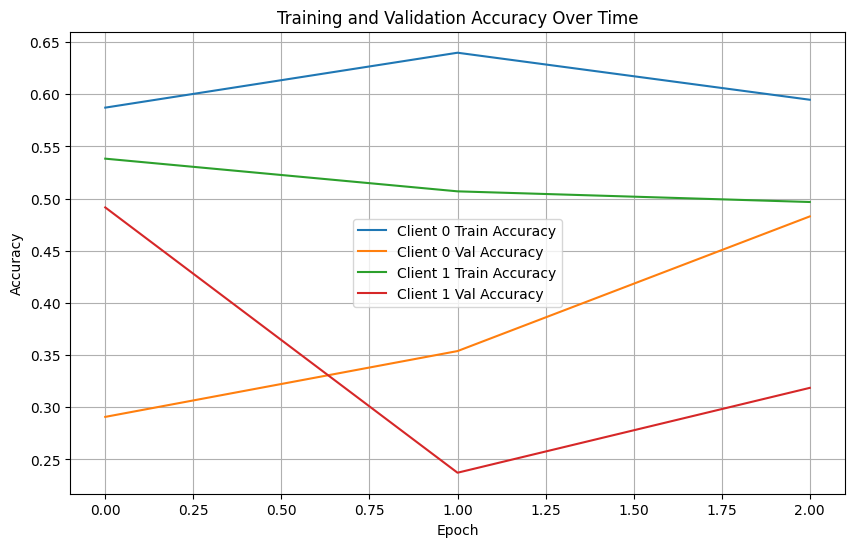

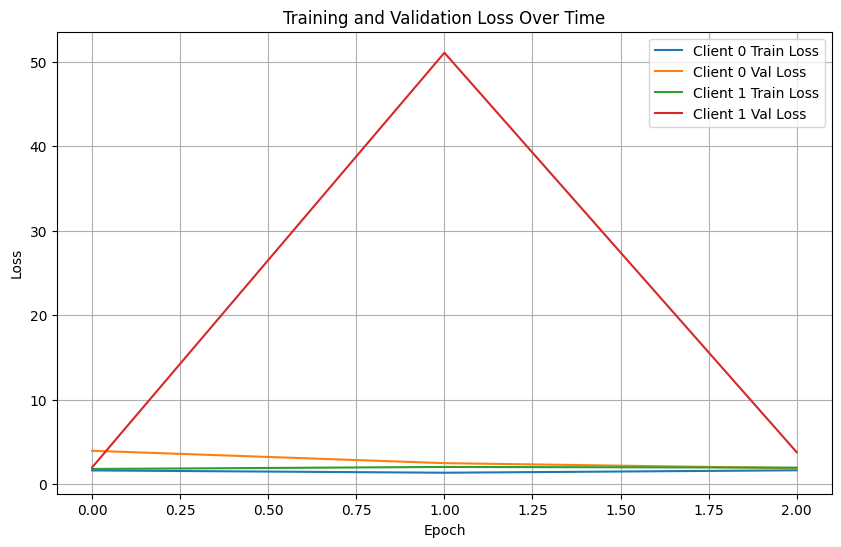

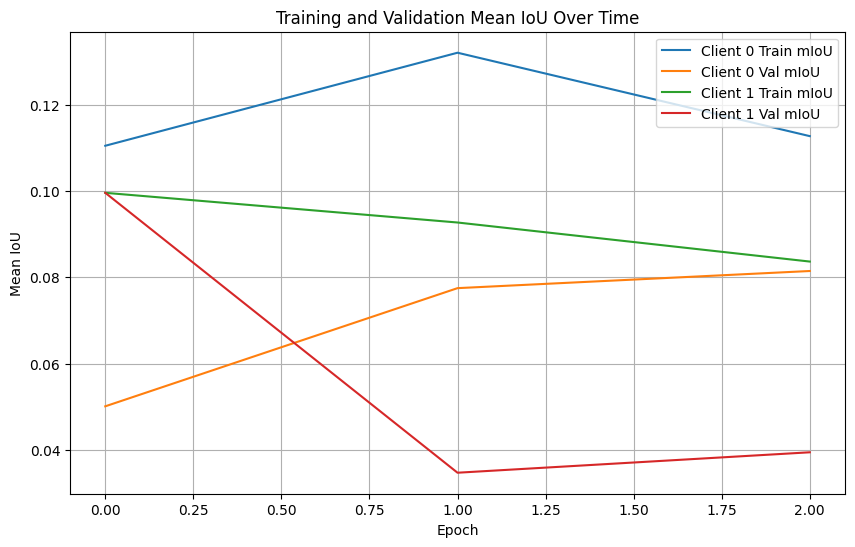

Epoch 1 histories:
  Client 0: {'train_loss': [1.6264482787231993], 'val_loss': [3.952797041998969], 'train_miou': [0.11051022390140144], 'val_miou': [0.0501134023615205], 'train_acc': [0.5871806087276505], 'val_acc': [0.29078261904078667], 'lrs': [0.0003999999999999993, 0.0004117446781449867, 0.00044692123863631326, 0.0005053575408984698, 0.0005867676201139361, 0.000690753086625152, 0.0008168050755004794, 0.0009643067367237183, 0.001132536253821155, 0.001320670376154123, 0.001527788447591421, 0.0017528769118467773, 0.001994834272434017, 0.0022524764829677593, 0.0025245427414316386, 0.0028097016600590807, 0.0031065577806336517, 0.003413658403325549, 0.0037295006956465917, 0.004052539046735159, 0.004381192630982075, 0.004713853143983932, 0.005048892672967082, 0.005384671663167463, 0.005719546941181845, 0.00605187975602731, 0.006380043798559122, 0.006702433160002989, 0.007017470190655777, 0.007323613220297163, 0.007619364102531537, 0.007903275546141009, 0.008173958197572707, 0.0084300874

In [38]:
# Plotting accuracy over time
train_accuracies = {i: [] for i in range(no_clients)}
val_accuracies = {i: [] for i in range(no_clients)}

for epoch_histories in histories:
    for i, history in enumerate(epoch_histories):
        train_accuracies[i].append(history["train_acc"][-1])
        val_accuracies[i].append(history["val_acc"][-1])

plt.figure(figsize=(10, 6))

for i in range(no_clients):
    plt.plot(train_accuracies[i], label=f"Client {i} Train Accuracy")
    plt.plot(val_accuracies[i], label=f"Client {i} Val Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss over time
train_losses = {i: [] for i in range(no_clients)}
val_losses = {i: [] for i in range(no_clients)}

for epoch_histories in histories:
    for i, history in enumerate(epoch_histories):
        train_losses[i].append(history["train_loss"][-1])
        val_losses[i].append(history["val_loss"][-1])

plt.figure(figsize=(10, 6))

for i in range(no_clients):
    plt.plot(train_losses[i], label=f"Client {i} Train Loss")
    plt.plot(val_losses[i], label=f"Client {i} Val Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plotting mean IoU over time
train_miou = {i: [] for i in range(no_clients)}
val_miou = {i: [] for i in range(no_clients)}

for epoch_histories in histories:
    for i, history in enumerate(epoch_histories):
        train_miou[i].append(history["train_miou"][-1])
        val_miou[i].append(history["val_miou"][-1])

plt.figure(figsize=(10, 6))

for i in range(no_clients):
    plt.plot(train_miou[i], label=f"Client {i} Train mIoU")
    plt.plot(val_miou[i], label=f"Client {i} Val mIoU")

plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.title("Training and Validation Mean IoU Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Display the detailed history for each client and each epoch
for e, epoch_histories in enumerate(histories):
    print(f"Epoch {e+1} histories:")
    for i, history in enumerate(epoch_histories):
        print(f"  Client {i}: {history}")